In [359]:
import numpy as np
from torch.utils.data import Dataset
import torch.nn as nn
import torch
from torch.autograd import Variable
import glob

In [360]:
import exchangable_tensor
from exchangable_tensor.sp_layers import mean_pool, SparsePool, SparseExchangeable, SparseSequential

In [361]:
reload(exchangable_tensor.sp_layers)
SparsePool = exchangable_tensor.sp_layers.SparsePool
SparseExchangeable = exchangable_tensor.sp_layers.SparseExchangeable
SparseSequential = exchangable_tensor.sp_layers.SparseSequential

In [362]:
from data.loader import IndexIterator
from data.samplers import ConditionalSampler, UniformSampler
from data import prep, collate_fn, CompletionDataset

In [363]:
use_cuda = False

In [364]:
def prep_data(x, requires_grad=False, use_cuda=True):
    '''
    Helper function for setting up data variables
    '''
    x = Variable(x, requires_grad=requires_grad)
    if use_cuda:
        x = x.cuda()
    return x

In [8]:
id = 2125
dat = np.load("data/sat_%06d.npz" % id)

In [11]:
dat.keys()

['indices', 'y_unsat', 'values', 'y_sat']

In [28]:
class SATDataset(Dataset):
    '''
    A dataset object for holding 
    '''
    def __init__(self, values, index, y_sat, y_unsat):
        self.index = np.array(index, dtype="int")
        self.y_sat = np.array(y_sat, dtype="int")
        self.y_unsat = np.array(y_unsat, dtype="int")
        self.values = np.array(values, dtype="float32").reshape(index.shape[0], -1) # ensure 2D

    def __len__(self):
        return self.index.shape[0]

    def __getitem__(self, index):
        return {"index": self.index[index, :], 
                "input": self.values[index, :], 
                "target": self.y_sat[index],
                "unsat": self.y_unsat[index]}

In [357]:
files = glob.glob("data/sat*")

In [350]:
def load_data(path, validation=0., seed=None):
    data = np.load(path)
    values = data['values']
    indices = data['indices']
    y_sat = data['y_sat']
    y_unsat = data['y_unsat']
    return SATDataset(values, indices, y_sat, y_unsat)



In [351]:
from torch.nn.init import xavier_uniform, normal

In [352]:
dat = load_data(files[0])

index = prep(dat.index, dtype="int")
index = index.cuda()

out_dim = 32
enc = SparseSequential(index, 
                       SparseExchangeable(2,250, index), 
                       nn.LeakyReLU(),
                      # torch.nn.Dropout(p=0.5),
                       SparseExchangeable(250,250, index),
                       nn.LeakyReLU(),
                       SparseExchangeable(250,150, index),
                       nn.LeakyReLU(),
                       #torch.nn.Dropout(p=0.5),
                       SparseExchangeable(150,150, index),
                       nn.LeakyReLU(),
                       #torch.nn.Dropout(p=0.5),
                       SparseExchangeable(150,out_dim, index),
                       SparsePool(index, out_dim, 1, keep_dims=False)
                   )
mod = torch.nn.Sequential(enc,
                          torch.nn.Linear(in_features=out_dim, out_features=16),
                          nn.LeakyReLU(),
                          torch.nn.Dropout(p=0.5),
                          torch.nn.Linear(in_features=16, out_features=1),
                          nn.Sigmoid())


#torch.nn.init.xavier_normal(w)

# as direct access to tensors data attribute
def weights_init(m):
    if isinstance(m, nn.Linear):
        xavier_uniform(m.weight.data)
        #m.weight.data.normal_(0.0, 0.02)


mod.apply(weights_init)
mod.cuda()

Sequential(
  (0): SparseSequential(
    (layers): ModuleList(
      (0): SparseExchangeable(
        (linear): Linear(in_features=8, out_features=250, bias=True)
        (row_pool): SparsePool(
        )
        (col_pool): SparsePool(
        )
      )
      (1): LeakyReLU(0.01)
      (2): SparseExchangeable(
        (linear): Linear(in_features=1000, out_features=250, bias=True)
        (row_pool): SparsePool(
        )
        (col_pool): SparsePool(
        )
      )
      (3): LeakyReLU(0.01)
      (4): SparseExchangeable(
        (linear): Linear(in_features=1000, out_features=150, bias=True)
        (row_pool): SparsePool(
        )
        (col_pool): SparsePool(
        )
      )
      (5): LeakyReLU(0.01)
      (6): SparseExchangeable(
        (linear): Linear(in_features=600, out_features=150, bias=True)
        (row_pool): SparsePool(
        )
        (col_pool): SparsePool(
        )
      )
      (7): LeakyReLU(0.01)
      (8): SparseExchangeable(
        (linear): Line

In [353]:
loss = nn.BCELoss()
optimizer = torch.optim.Adam(mod.parameters(), lr=0.001)

In [354]:
perf = []
batch_size = 100

In [358]:
len(files)

19946

In [347]:
#mod = torch.load('./firstmod.pt')

In [355]:
for epoch in xrange(100000):
    enc.train()
    optimizer.zero_grad()
    loss_batch = 0.
    av_acc = 0.
    for _ in xrange(batch_size):
        i = np.random.randint(0, len(files))
        dat = load_data(files[i])
        input = prep_data(torch.from_numpy(dat.values))
        index = prep_data(torch.from_numpy(dat.index))
        enc.index = index
        input = input.cuda()
        y_sat = dat.y_sat[:,0]
        y_sat[y_sat == -1] = 0
        target = prep_data(torch.from_numpy(y_sat))
        target = target.cuda()
        out = mod(input)
        loss_i = loss(out, target.float())
        loss_batch = loss_batch + loss_i
        acc = np.mean(np.abs(np.round(out.cpu().data.numpy()).flatten() - y_sat))
        av_acc += acc
        #print(acc)
        #print(loss_i.cpu().data.numpy())
        #print(np.array(np.round(out.cpu().data.numpy()).flatten(), "int"))
        #print(y_sat)
    av_acc = av_acc / (1. * batch_size)
    loss_batch = loss_batch / (1.* batch_size)
    if epoch % 1 == 0:
        p_loss = loss_batch.cpu().data.numpy()[0]
        print epoch, p_loss, av_acc
        perf.append(p_loss)
    loss_batch.backward()
    optimizer.step()
    

0 0.6947706 0.5015
1 0.6972311 0.5005
2 0.6965185 0.5059999999999998
3 0.6981803 0.4890000000000001
4 0.7037452 0.5025000000000001
5 0.6923251 0.41849999999999987
6 0.69090664 0.47800000000000004
7 0.6885369 0.47799999999999976
8 0.68840015 0.455
9 0.68788797 0.4790000000000002
10 0.6876102 0.44050000000000034
11 0.6877117 0.4759999999999999
12 0.68319714 0.4125000000000001
13 0.6768598 0.3975
14 0.6765159 0.40099999999999986
15 0.66746503 0.3525


KeyboardInterrupt: 

In [245]:
def is_sat(X, y):
    test = X.dot(y) == -3
    return test.sum(axis=0) == 0

In [ ]:
n = 2000000
variables = 20
clauses = int(4.258 * variables + 58.26 * variables **(-2/3))
k = 3
n_examples = 50000

for item in tqdm(xrange(n_examples)):
    a = cnfformula.RandomKCNF(k=k,n=variables,m=clauses)
    X = csr_matrix((clauses, variables), dtype="int")

    indices = []
    values = []

    for i, clause in enumerate(a.clauses()):
        for term in clause:
            v_i = int(term[1].split("_")[1]) - 1
            v_v = -(1 - 2*int(term[0]))
            X[i, v_i] = v_v
            indices.append([i,v_i])
            v = [1,0] if v_v == 1 else [0, 1]
            values.append(v)
    indices = np.array(indices)
    values = np.array(values)

    t = time.time()
    y = 1 - 2 * np.random.randint(0, 2, [variables, n])
    test = X.dot(y) == -3
    is_sat = test.sum(axis=0) == 0
    y_sat = y[:, is_sat]
    y_unsat = y[:, np.logical_not(is_sat)][:, 0:200]
    sat = "sat" if np.sum(test.sum(axis=0) == 0) > 0 else "unsat"
    np.savez_compressed("data/%s_%06d.npz" % (sat, item),
                        indices=indices, values=values,
                        y_sat=y_sat, y_unsat=y_unsat)

In [250]:
from scipy.sparse import csr_matrix

In [344]:
torch.save(mod, 'firstmod.pt')
#model = torch.load('firstmod.pt')

In [253]:
dat.index.max(axis=0)

array([87, 19])

In [257]:
#np.dot(dat.values, np.array([[1], [-1]]))
X_sp = csr_matrix((np.dot(dat.values, np.array([[1], [-1]])).flatten(), 
                  (dat.index[:, 0],dat.index[:, 1])), 
                  shape=dat.index.max(axis=0) + 1)

In [269]:
is_sat(X_sp, y.cpu().data.numpy().flatten().round())

False

In [341]:
len(files)
new_files = glob.glob("data/sat*")
new_files = list(set(new_files).difference(set(files)))

In [340]:
len(set(new_files).difference(set(files)))

13447

In [343]:
mod.eval()
#i = np.random.randint(0, len(files))
i = 0
perc_sat = 0
for i in range(100):
    #dat = load_data("./data/sat_%06d.npz" % i)
    dat = load_data(new_files[i])
    input = prep_data(torch.from_numpy(dat.values))
    input = input.cuda()
    index = prep_data(torch.from_numpy(dat.index))
    enc.index = index
    y_sat = dat.y_sat[:,0]
    y_sat[y_sat==-1] = 0
    target = prep_data(torch.from_numpy(y_sat))
    target = target.cuda()
    loss_batch = loss_batch + loss(mod(input), target.float())

    #print loss(mod(input), target.float())

    X_sp = csr_matrix((np.dot(dat.values, np.array([[1], [-1]])).flatten(), 
                      (dat.index[:, 0],dat.index[:, 1])), 
                      shape=dat.index.max(axis=0) + 1)
    y = mod(input)
    y_hat = y.cpu().data.numpy().flatten().round()
    y_hat = 1 - 2* y_hat
    y_hat = -1 * y_hat
    perc_sat += int(is_sat(X_sp, y_hat))
print perc_sat / 100.

0.04


In [309]:
y_hat.shape

(20,)

In [310]:
y_hat

array([-1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1., -1.,  1.], dtype=float32)

In [311]:
dat.y_sat[:, 0]

array([-1,  1, -1, -1, -1, -1,  1,  1, -1,  1, -1, -1,  1,  1, -1,  1,  1,
       -1,  1, -1])

In [312]:
for i in range(21):
    print i, np.sum(dat.y_sat[:,i] == y_hat)

0 10
1 11
2 12
3 11
4 11
5 11
6 11
7 11
8 12
9 12
10 11
11 10
12 9
13 11
14 10
15 10
16 12
17 11
18 11
19 10
20 10


In [284]:
dat.y_sat.shape

(20, 21)

In [273]:
y_hat

array([-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1.,
       -1.,  1., -1.,  1., -1., -1., -1.], dtype=float32)

In [264]:
y = mod(input)
#torch.log(y) * target.float() + torch.log(1-y) * (1-target.float())

In [268]:
y.cpu().data.numpy().flatten().round()

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)

In [178]:
target

Variable containing:
-1
 1
-1
-1
 1
-1
 1
-1
-1
-1
 1
 1
-1
-1
 1
-1
-1
-1
 1
 1
[torch.cuda.LongTensor of size 20 (GPU 0)]

In [313]:
from matplotlib import pyplot as plt

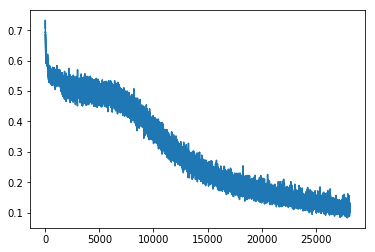

In [314]:
plt.plot(perf)